# Import

In [1]:
# torch package
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# dataset packagea
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

# metrcis
from sklearn.metrics import accuracy_score, classification_report

# ETC
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Simple-RNN Model

In [2]:
class SimpleRNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config


        self.embedding = nn.Embedding(num_embeddings=config.vocab_size,
                                     embedding_dim=config.em_output)
        
        # batch_size, sequence_size, embeding_size
        self.rnn_1 = nn.RNN(input_size=config.em_output,
                            hidden_size=config.rnn_node1,
                            num_layers=1,
                            batch_first=True)
        
        self.drop_out = nn.Dropout(p=config.drop_out_rate)
        
        self.rnn_2 = nn.RNN(input_size=config.rnn_node1,
                            hidden_size=config.rnn_node2,
                            num_layers=1,
                            batch_first=True)
        
        self.dense = nn.Linear(in_features=config.rnn_node2, out_features=1)


    def forward(self, x):
        ebd = self.embedding(x)
        rnn1_output, _ = self.rnn_1(ebd)
        drop_layer = self.drop_out(rnn1_output)
        rnn2_output, _ = self.rnn_2(drop_layer)
        drop_layer = self.drop_out(rnn2_output)
        dense_output = self.dense(drop_layer[:, -1, :])
        sigmoid_output = torch.sigmoid(dense_output)
        # final_output = (sigmoid_output > 0.5).float().view(-1)
        

        return sigmoid_output    

# Train

In [3]:
def train(model, config, train, valid, optimizer=False, loss=False):
    train_loss_history = []
    valid_loss_history = []
    
    optimizer = optimizer if optimizer else optim.Adam(model.parameters(), lr=config.learning_rate)
    loss_function = loss if loss else nn.BCELoss()


    for i in range(config.epochs):

        train_loss_ = 0
        model.train()
        with torch.enable_grad():
            for feature, label in train:
                optimizer.zero_grad()
                outputs = model(feature).view(-1)
                loss = loss_function(outputs, label)
                # loss.requires_grad_(True)
                loss.backward()
                optimizer.step()

                train_loss_ += loss.item()

        train_loss_ /= config.batch_size
        train_loss_history.append(train_loss_)


        valid_loss_ = 0
        model.eval()
        with torch.no_grad():
            for feature, label in valid:
                outputs = model(feature)
                loss = loss_function(outputs.reshape(-1), label)
                
                valid_loss_ += loss.item()

        valid_loss_ /= config.batch_size
        valid_loss_history.append(valid_loss_)

        if (i+1)%int((config.epochs)*0.1)==0:
            print(f"epoch : {i+1} Loss(train) : {train_loss_history[-1]:.3f}  Loss(valid) : {valid_loss_history[-1]:.3f}")


    
    plt.plot(train_loss_history, label='Training loss')
    plt.plot(valid_loss_history, label='Validation loss')
    plt.legend()
    plt.show()
    print("="*40)
    print("Training loss: ", train_loss_history[-1])
    print("Validation loss: ", valid_loss_history[-1])
    print("="*40)

# Predict

In [4]:
def predict_evaluate(model, test):
    model.eval()
    output_list = []
    acc = []

    y_pred = []
    y_test = []
    with torch.no_grad():
        for feature, label in test:
            outputs = model(feature)
            output_list.append(outputs)
            outputs = outputs.cpu()
            outputs = (outputs > 0.5).float().view(-1)

            label = label.cpu()
            acc.append(accuracy_score(label, outputs))
            y_pred.append(outputs)
            y_test.append(label)


    print(f"Accuracy: {(sum(acc)/len(acc)):.3f}")

    return np.array(y_test).reshape(-1), np.array(y_pred).reshape(-1)

# Hyperparameter config

In [5]:
class config():
    def __init__(self, max_size, vocab_size, em_output, rnn_node1, rnn_node2, drop_out_rate=0.5, learning_rate=0.001, patience_ratio=0.2, epochs=100, 
                 validation_split=0.2, batch_size = 128):
        
        self.vocab_size = vocab_size
        self.em_output = em_output
        self.max_size = max_size

        self.rnn_node1 = rnn_node1
        self.rnn_node2 = rnn_node2
        self.drop_out_rate =drop_out_rate
        self.learning_rate = learning_rate
        self.patience = epochs * patience_ratio
        self.batch_size = batch_size
        self.epochs = epochs
        self.validation_split = validation_split

        self.device = device

# Dataset

In [6]:
class IMDBDataset(Dataset):
    def __init__(self, X, y, max_size, device):
        X_np = np.array([np.array(xi) for xi in X],dtype=object)
        X_pad = np.zeros((len(X_np), max_size))
        for i in range(len(X)):
            pad_length = min(len(X_np[i]), max_size)
            X_pad[i, :pad_length] = X_np[i][:pad_length]

        self.X = torch.Tensor(X_pad).long().to(device)
        self.y = torch.Tensor(y).to(device)


    def __len__(self):
        return len(self.X)


    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
max_len = 100 # rnn의 장기의존성 이슈 때문에 max_len이 길 경우 학습이 제대로 진행되지 않음
vocab_size = 10000
batch_size = 200

(X_trian, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
X_train, X_valid, y_train, y_valid = train_test_split(X_trian, y_train, train_size=0.8, stratify=y_train)


train_dataset = IMDBDataset(X_train, y_train, max_len, device=device)
valid_dataset = IMDBDataset(X_valid, y_valid, max_len, device=device)
test_dataset = IMDBDataset(X_test, y_test, max_len, device=device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [8]:
print(f"train shape: {train_dataset.X.shape}")
print(f"valid shape: {valid_dataset.X.shape}")
print(f"test shape : {test_dataset.X.shape}")

train shape: torch.Size([20000, 100])
valid shape: torch.Size([5000, 100])
test shape : torch.Size([25000, 100])


# Model

In [9]:
rnn_config = config(vocab_size=vocab_size,
                    max_size=max_len,
                    em_output=64,

                    rnn_node1=64,
                    rnn_node2=32,

                    drop_out_rate=0.5,
                    learning_rate=0.001,
                    # patience_ratio=0.3,
                    epochs=150,
                    batch_size=batch_size,
                    )

In [10]:
rnn = SimpleRNN(rnn_config).to(device)

epoch : 15 Loss(train) : 0.332  Loss(valid) : 0.082
epoch : 30 Loss(train) : 0.333  Loss(valid) : 0.086
epoch : 45 Loss(train) : 0.250  Loss(valid) : 0.082
epoch : 60 Loss(train) : 0.229  Loss(valid) : 0.091
epoch : 75 Loss(train) : 0.172  Loss(valid) : 0.104
epoch : 90 Loss(train) : 0.168  Loss(valid) : 0.107
epoch : 105 Loss(train) : 0.117  Loss(valid) : 0.123
epoch : 120 Loss(train) : 0.193  Loss(valid) : 0.101
epoch : 135 Loss(train) : 0.115  Loss(valid) : 0.129
epoch : 150 Loss(train) : 0.106  Loss(valid) : 0.135


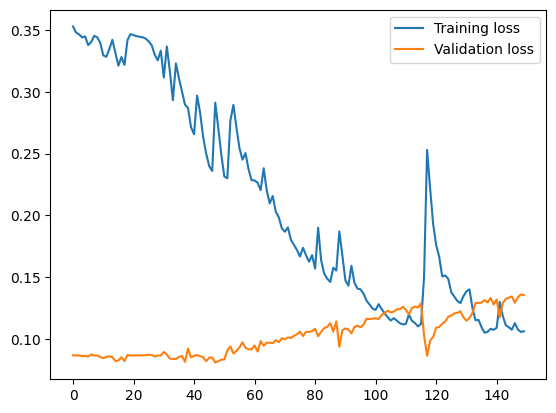

Training loss:  0.10610217165201902
Validation loss:  0.13542403072118758


In [11]:
train(rnn, rnn_config, train_loader, valid_loader)

# Evaluation

In [12]:
y_test, y_pred = predict_evaluate(rnn, test_loader)

Accuracy: 0.616


In [13]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.56      0.59     12500
         1.0       0.60      0.67      0.64     12500

    accuracy                           0.62     25000
   macro avg       0.62      0.62      0.62     25000
weighted avg       0.62      0.62      0.62     25000

